In [299]:
import networkx as nx
import matplotlib.pyplot as plt
import os
from fa2 import ForceAtlas2
import random


In [300]:
def load_file(file_path):
#     data_path = "../../data/ground-truth/Sparse/n=200d=6"
    f = open(file_path)
    edge_list = []
    data_list = []
    for line in f.readlines():
        data_list.append(line.strip())
    num_nodes = int (data_list.pop(0)) #Pop out the number of nodes 

    for i in range(num_nodes+1,len(data_list)):
        edge_list.append(tuple([int(data_list[i].strip('\n').split(" ")[0]), int(data_list[i].strip('\n').split(" ")[1])]))
    return edge_list, num_nodes, file_path.split("/")[-1]

In [301]:
def store(pos_dict, edges_list, target_graph_path):
    with open(target_graph_path,"w+") as f:
        f.write(str(len(pos_dict)) + "\n")
        for num, pos in pos_dict.items():
            f.write(str(num) + " " + str(float(pos[0])) + " " + str(float(pos[1])) + "\n")
        f.write(str(len(edges_list)) + "\n")
        for edge in edges_list:
            f.write(str(edge[0]) + " " + str(edge[1]) + "\n")
        f.close()


In [302]:
def scale_coordinates(coords, new_range):
    """将坐标等比例放大，并调整范围适合给定的范围"""
    # 找到坐标的最小值和最大值
    min_coord = min(coords)
    max_coord = max(coords)

    # 将为负的坐标变为正
    if min_coord < 0:
        for i in range (len(coords)):
            coords[i] = coords[i] + min_coord * -1

    # 计算坐标的范围
    coord_range = max_coord - min_coord

    # 计算缩放比例
    if coord_range == 0:
        scale_factor = 1.0
    else:
        scale_factor = float(new_range) / coord_range

    # 缩放坐标
    scaled_coords = [int(round((c - min_coord) * scale_factor)) for c in coords]
    return scaled_coords


In [303]:
def pos_calculation(pos_dict, new_range=1000):
    node_x = []
    node_y = []
    for key, value in pos_dict.items():
        node_x.append(value[0])
        node_y.append(value[1])
    scaled_x = scale_coordinates(node_x, new_range)
    scaled_y = scale_coordinates(node_y, new_range)
    result_dict = {}
    for i in range(len(scaled_x)):
        result_dict[i] = [scaled_x[i], scaled_y[i]]
    return result_dict
    

In [304]:
def fr_nx(edges_list,type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define spring layout and draw graph
    pos_dict = nx.fruchterman_reingold_layout(G, k=0.3, iterations=100)
    nx.draw(G, pos_dict, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
            
    # Set edge weights and draw graph
    # nx.draw_networkx_edges(G, pos_dict, width=weights)

    return pos_dict

In [305]:
def kk_nx(edges_list, type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define Kamada-Kawai layout and draw graph
    pos_dict = nx.kamada_kawai_layout(G)
    nx.draw(G, pos_dict, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
        
    # Set edge weights and draw graph
    # nx.draw_networkx_edges(G, pos_dict, width=weights)
    print(pos_dict)
    return pos_dict

In [306]:


# Define function to create graph
def jiggle_nx(edges_list, type,iterations=100, scale=1):
    
    # initialize the positions of the nodes randomly
    positions = np.random.rand(len(G), 2)
    
    # iterate over the number of iterations
    for i in range(iterations):
        # calculate the repulsive forces between nodes
        repulsive_forces = np.zeros_like(positions)
        for u, pos_u in enumerate(positions):
            for v, pos_v in enumerate(positions):
                if u != v:
                    diff = pos_u - pos_v
                    distance = np.sqrt(np.sum(diff ** 2))
                    if distance > 0:
                        repulsive_forces[u] += (diff / distance) / distance
        
        # calculate the attractive forces between adjacent nodes
        attractive_forces = np.zeros_like(positions)
        for u, v in G.edges():
            diff = positions[u-1] - positions[v-1]
            distance = np.sqrt(np.sum(diff ** 2))
            attractive_forces[u-1] -= diff * distance
            attractive_forces[v-1] += diff * distance
            
        # calculate the total force acting on each node
        total_forces = repulsive_forces + attractive_forces
        
        # update the positions of the nodes based on the total force
        positions += scale * total_forces
    
    # return the final positions of the nodes
    return positions




In [307]:
def jiggle_layout_sparse(G, iterations=100, k=1, c=0.05):
    # Convert the graph to a sparse matrix
    adj_matrix = nx.to_scipy_sparse_array(G)

    # Initialize node positions
    positions = np.random.rand(G.number_of_nodes(), 2)

    # Perform jiggle force-directed algorithm
    for i in range(iterations):
        # Compute repulsive forces
        repulsive_forces = np.zeros_like(positions)
        for u in G.nodes:
            for v in G.nodes:
                if u != v:
                    diff = positions[u] - positions[v]
                    norm = np.linalg.norm(diff)
                    if norm > 0:
                        repulsive_forces[u] += diff / norm**2

        # Compute attractive forces
        attractive_forces = np.zeros_like(positions)
        for u, v in G.edges:
            diff = positions[u] - positions[v]
            norm = np.linalg.norm(diff)
            attractive_forces[u] -= k * diff / norm**2
            attractive_forces[v] += k * diff / norm**2

        # Update node positions
        forces = c * repulsive_forces + attractive_forces
        positions += forces

    return positions

def jiggle_layout_uniform(G, iterations=100, k=1, c=0.05):
    # Convert the graph to a numpy matrix
    adj_matrix = nx.to_numpy_array(G)

    # Initialize node positions
    positions = np.random.rand(G.number_of_nodes(), 2)

    # Perform jiggle force-directed algorithm
    for i in range(iterations):
        # Compute repulsive forces
        repulsive_forces = np.zeros_like(positions)
        for u in G.nodes:
            for v in G.nodes:
                if u != v:
                    diff = positions[u] - positions[v]
                    norm = np.linalg.norm(diff)
                    if norm > 0:
                        repulsive_forces[u] += diff / norm**2

        # Compute attractive forces
        attractive_forces = np.zeros_like(positions)
        for u, v in G.edges:
            diff = positions[u] - positions[v]
            norm = np.linalg.norm(diff)
            attractive_forces[u] -= k * diff / norm**2
            attractive_forces[v] += k * diff / norm**2

        # Update node positions
        forces = c * repulsive_forces + attractive_forces
        positions += forces

    return positions

def jiggle_type(edge_list, node_num, type):
    G = nx.Graph()
    G.add_nodes_from(range(node_num))
    G.add_edges_from(edge_list)
    result_dict = {}
    if type == 'Sparse':
        positions = jiggle_layout_sparse(G)
    elif type == 'Uniform':
        positions = jiggle_layout_uniform(G)
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
    for i in range(len(positions)):
        result_dict[i] = positions[i]

    return result_dict

In [308]:
def fa2_type(edges_list, node_num, type):
    G = nx.Graph()
    G.add_nodes_from(range(node_num))
    G.add_edges_from(edges_list)
    result_dict = {}
    input_positions = {}
    # Generate initial positions using uniform distribution or sparse distribution
    if type == 'Sparse':
        input_positions = nx.spring_layout(G, seed=42)
    elif type == 'Uniform':
        input_list = np.random.uniform(low=-1, high=1, size=(node_num, 2))
        for i in range(len(input_list)):
            input_positions[i] = input_list[i]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
    print(input_positions)
    # Run the FA2 algorithm to optimize the node positions
    fa2 = ForceAtlas2(
        outboundAttractionDistribution=True,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0
    )
    
    result_dict = fa2.forceatlas2_networkx_layout(G, pos=input_positions, iterations=100)
    
    return result_dict


In [315]:
def generate(file_path, target_graph_path):
    type_list = ["Sparse", "Uniform"]
    degree_list = [6,8,10,12,15]
    for d in degree_list:
        for type in type_list:
            edges_list, num_nodes, fname = load_file(os.path.join(file_path, type, "n=200d="+str(d)))
            target_type_path = os.path.join(target_graph_path, type)
            fr_path = os.path.join(target_type_path,"FR",fname+".graph")
            pos_dict = fr_nx(edges_list, type)
            pos_dict = pos_calculation(pos_dict)
            store(pos_dict, edges_list, fr_path)

            fa2_path = os.path.join(target_type_path,"FA2",fname+".graph")
            pos_dict = fa2_type(edges_list, num_nodes, type)
            pos_dict = pos_calculation(pos_dict)
            store(pos_dict, edges_list, fa2_path)

            kk_path = os.path.join(target_type_path,"KK",fname+".graph")
            pos_dict = kk_nx(edges_list, type)
            pos_dict = pos_calculation(pos_dict)
            store(pos_dict, edges_list, kk_path)

            jiggle_path = os.path.join(target_type_path,"JIGGLE",fname+".graph")
            pos_dict = jiggle_type(edges_list, num_nodes, type)
            pos_dict = pos_calculation(pos_dict)
            store(pos_dict, edges_list, jiggle_path)




FR saved. ../../Data/graph_files/Sparse/FR/n=200d=6.graph
{0: array([0.31055672, 0.35835561]), 1: array([ 0.0008899 , -0.88626145]), 2: array([-0.17030817, -0.91235823]), 3: array([-0.0159202 ,  0.50951695]), 4: array([-0.27309869,  0.27320669]), 5: array([-0.29622259,  0.18055826]), 6: array([-0.19067338,  0.59402969]), 7: array([0.35077002, 0.13372048]), 8: array([ 0.02486356, -0.68562384]), 9: array([-0.146441  ,  0.41612465]), 10: array([-0.12524007, -1.        ]), 11: array([-0.01666435, -0.88514691]), 12: array([ 0.54354236, -0.55615935]), 13: array([-0.22691917,  0.457214  ]), 14: array([0.3484873 , 0.07887272]), 15: array([0.30499201, 0.01084822]), 16: array([-0.02005896,  0.03695292]), 17: array([0.36886702, 0.24501135]), 18: array([-0.22445727,  0.57021558]), 19: array([ 0.44526966, -0.68064714]), 20: array([-0.26113804,  0.38903934]), 21: array([-0.32741067,  0.50271178]), 22: array([-0.19350165,  0.51926778]), 23: array([ 0.06463767, -0.64177732]), 24: array([0.01945312, 0.

100%|██████████| 100/100 [00:00<00:00, 813.14it/s]


BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.03  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds
FA2 saved. ../../Data/graph_files/Sparse/FA2/n=200d=6.graph
{0: array([0.20890404, 0.42970787]), 71: array([0.09939997, 0.46404227]), 120: array([0.17484435, 0.38267081]), 124: array([0.13665092, 0.34900055]), 179: array([0.2251139 , 0.30587227]), 180: array([0.29392786, 0.40722505]), 1: array([ 0.71876918, -0.45779089]), 11: array([ 0.71482305, -0.41089812]), 38: array([ 0.71930783, -0.53908014]), 39: array([ 0.83771785, -0.39308605]), 46: array([ 0.77573693, -0.46281941]), 51: array([ 0.74242465, -0.33936831]), 79: array([ 0.77484849, -0.40431288]), 137: array([ 0.72597835, -0.58950458]), 166: array([ 0.77966919, -0.51535726]), 176: array([ 0.66025201, -0.53525723]), 2: array([ 0.91894242, -0.23586822]), 193: array([ 0.80387715, -0.28565037]), 3: array([-0.14188693,  0.46

100%|██████████| 100/100 [00:00<00:00, 1985.63it/s]


BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.03  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds
FA2 saved. ../../Data/graph_files/Uniform/FA2/n=200d=6.graph
{0: array([ 0.47681976, -0.01149899]), 12: array([0.32549135, 0.0162884 ]), 22: array([ 0.36880298, -0.12322048]), 59: array([0.58764698, 0.0951087 ]), 79: array([0.43483871, 0.11588093]), 149: array([ 0.62135873, -0.04490652]), 1: array([ 0.10904729, -0.10325882]), 20: array([0.16627556, 0.0537488 ]), 82: array([ 0.20912602, -0.05331363]), 89: array([-0.03689977, -0.19446418]), 108: array([-0.04462656, -0.0973516 ]), 140: array([ 0.24218999, -0.19224892]), 143: array([ 0.08711588, -0.18532031]), 188: array([ 0.26973943, -0.12569148]), 2: array([-0.66579576, -0.06627049]), 88: array([-0.69712222, -0.16299536]), 90: array([-0.81288179, -0.14634812]), 98: array([-0.54898079, -0.08922614]), 120: array([-0.5919667,  0

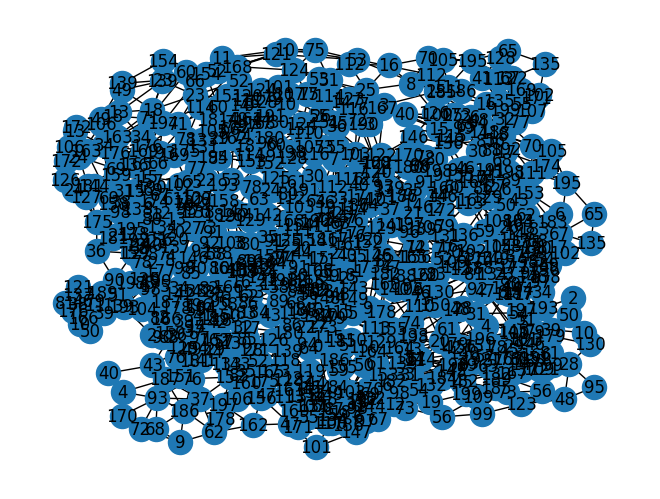

In [316]:
generate("../../Data/ground-truth","../../Data/graph_files")